<h2> Buisiness Understanding</h2>

*<h3>1. Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?)</h3>*

<h4>PatchCamelyon dataset is used from histopathological cancer detection challenge on Kaggle [1]. It consists of 327,680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections each annotated with a label indicating the presence or absence of metastatic tissue[2]. PCam is derived from the Camelyon16 Challenge [3], which contains 400 H&E stained Whole Slide Images of sentinel lymph node sections.</h4>

*<h3>2.	Why is this data important?</h3>*

<h4>Detecting the presence of metastases in the regional lymph nodes allow for adequate treatment and better survival rates in patients affected by breast cancer. By the time cancer metastases to regional lymph nodes, the survival rate drops to 85% from 99% and it drops to 26% in the case of distant metastases.  Hence, it is of utmost importance to detect the presence of metastases as quickly as possible. Globally, the tumor, node, metastasis (TNM) staging criteria is used for establishing the presence or absence of metastases in the lymph nodes. In this procedure, the sentinel node, which is most likely to contain the metastasized cancer cells and is excised and is submitted for histopathological processing and examination by a pathologist.

Based on solitary tumor cells or the diameter of clusters of tumor cells in a tissue section of the lymph node stained with hematoxylin and eosin (H&E), metastases can be divided into one of three categories: macro-metastases, micro-metastases, or isolated tumor cells (ITC). Based on the presence or absence of one or more of these metastases, an initial pathological N-stage (pN-stage) is assigned to a patient. 

For this, a pathologist would have to perform an extensive microscopic examination of a large area of tissue to identify metastases as small as single cells. This examination process is tedious, time-consuming and subjective as pathologists may miss small metastases. Hence, an automated solution would greatly help this process.</h4>

*<h3>3.	What is the prediction task for your dataset?</h3>*

<h4>Given a whole slide image, the task would involve predicting the presence of metastases and probably the type of metastases in the patient’s sentinel node. This can be achieved by looking for specific cues within the captured image that differentiates a normal cell from a tumor cell.  The following illustration from [Cancer Cells vs. Normal Cells] gives a good understanding of what features we are looking for in the image:<br><br>

![image.png](attachment:image.png)

<br><br>
What cues are we looking for?
a.	Clustering of cells.
b.	Morphological differences such as shape of nuclei, shape of cell.
c.	Size of cells.
d.	Appearance of cells: The nucleus appears both larger and darker than normal cells. The reason for the darkness is that the nucleus of cancer cells contains excess DNA.</h4>

*<h3>4.	Which third parties would be interested in the results?</h3>*

<h4>Health care providers, pathology laboratories would generally be interested in an algorithm that can automate the cancer detection process. Governments and NGOs working in health care sector might also be interested in such an algorithm as this might reduce the cost and time required for pathological analysis of cancer patients thereby allowing for large scale screening of the populace. The procedure is still invasive and there is a large degree of manual intervention required in collecting samples and preparing slides which would be the bottleneck. </h4>


*<h3>5.	Once you begin modeling, how well would your prediction algorithm need to perform to be considered useful to the identified third parties?</h3>*

<h4>The evaluation metric chosen for this Kaggle competition is the area under the receiver operating characteristic (ROC) curve. It is a plot of the cumulative probability distribution (CDF) of true positive rate against CDF of false positive rate at various threshold parameters, T.  The threshold determines the class in a binary classification task. In the best-case scenario, the area of under the curve would be 1, which indicates that all positive samples are classified correctly without getting any false positives. 
State-of-the-art algorithms for an earlier version of this task have scored a ROC of 0.994 whereas the best pathologist could only score a 0.884 ROC [4]. The goal of our prediction algorithm would be to improve the state-of-the-art ROC of 0.994 for it to be considered useful.</h4>

References:
1. https://www.kaggle.com/c/histopathologic-cancer-detection
2. https://github.com/basveeling/pcam
3. https://camelyon16.grand-challenge.org/
4. https://jamanetwork.com/journals/jama/fullarticle/2665774


In [1]:
import os
from PIL import Image
import pandas as pd
from matplotlib.pyplot import imshow
import numpy as np
%matplotlib inline
vectorized_images = []
directory = os.fsencode('train/')
labels = 0
image_titles = []
targets = []
with open('train/train_labels.csv', 'r') as labels:
    labels = pd.read_csv(labels)
for idx, entry in labels.tail(-1).iterrows():
#     print(entry)
    with Image.open('train/' + entry['id'] + '.tif').convert('L') as image:
        image_titles.append(entry['id'])
        targets.append(entry['label'])
        vectorized_images.append(np.asarray(image).reshape(9216))


(9216,)


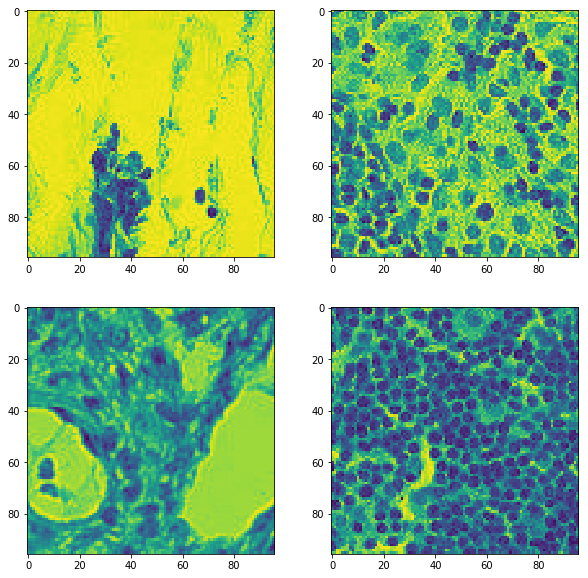

In [2]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
for idx in range(4):
    fig.add_subplot(2,2,idx+1)
    imshow(vectorized_images[idx].reshape((96,96)))
print(vectorized_images[0].shape)

In [3]:
# vec_images = vectorized_images[0]
import gc
vec_images = np.zeros((10000,9216))

for idx, img in enumerate(vectorized_images[:10000]):
    vec_images[idx,:] = img

vec_images_fl32 = vec_images.astype(np.float32)
vectorized_images = []
gc.collect()

21

<h2> Data reduction </h2><br>

*<h3> Linear dimensionality reduction</h3>*

<h4>In this task, we have performed linear dimensionality reduction using principal component analysis. The RGB images of size 96 X 96 X 3 pixels are converted to grayscale images. So, in total, the data is in 9216 dimensions. The objective here is to reduce the dimensions of the data while still maintaining the information content in each of the images. We started at about and went to about about 3000 dimensions while observing the explained variance. </h4>

*<h4>What do we expect from PCA?</h4>*
    
<h4>As mentioned earlier, the normal cells do not form clusters and have distinct morphological features. This would imply that we need large number of dimensions to explain the variance of normal cells. Whereas, cancerous cells tend to form big clusters and also are large in size. In an extreme scenario, cancer cells can ocupy the total image field of view and have very less variace within the image. Thus, we believe, images containing cancerous cells can be adequately represented by fewer dimensions than the images that do not contain cancerous cells. </h4>

*<h4>Analysis procedure</h4>*

<h4> After reducing the dimensions, we looked at the reconstruction error independantly for images with cancerous cells and images with normal cells. As expected, the images with normal cells required more dimensions than the images with normal cells to obtain the same reconstruction error.</h4>
<h4>For computing the reconstruction error, we have used SSIM (structural similrity index). Unlike MSE and PSNR, SSIM is useful when lots of structure is present in an image. SSIM captures the local spatial variations in the data whereas MSE and PSNR give error in a global sense. Thus, when images appear similar, SSIM values increase even though the actual pixel values might differ. It does so by computating a weighted combination of three terms, luminance term, contrast term and the structural term.<br>
    
![image.png](attachment:image.png)

<br>

</h4>

*<h3> Non linear dimensionality reduction</h3>*
<h4>In this task, we have performed nonlinear dimensionality reduction using kernel principal component analysis (kPCA). Intrestingly, the reconstruction errors obtained by this method are larger than liner PCA</h4>

In [4]:
from sklearn.decomposition import PCA, KernelPCA
import matplotlib.pyplot as plt

n_comp = 3000
pca = PCA(n_components=n_comp)
pca.fit_transform(vec_images)


kpca = KernelPCA(n_components= n_comp, kernel="rbf", fit_inverse_transform=True, gamma=10)
X_kpca = kpca.fit(vec_images)


In [5]:
print(sum(pca.explained_variance_ratio_) * 100, '% of variance explained')


94.89670092084252 % of variance explained


(3000, 9216)


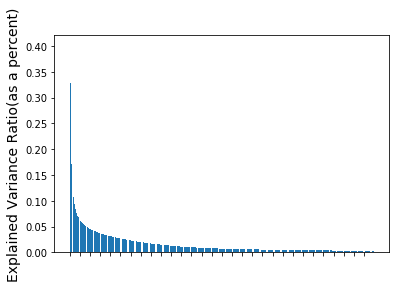

In [6]:
fig,ax = plt.subplots(1)
ax.set_xticklabels([])
plt.ylabel('Explained Variance Ratio(as a percent)', fontsize=14)
plt.ylim([0,max(pca.explained_variance_ratio_)])
plt.xticks(np.arange(n_comp, step = 100))
plt.bar(np.arange(n_comp), pca.explained_variance_ratio_*100)

print(pca.components_.shape)

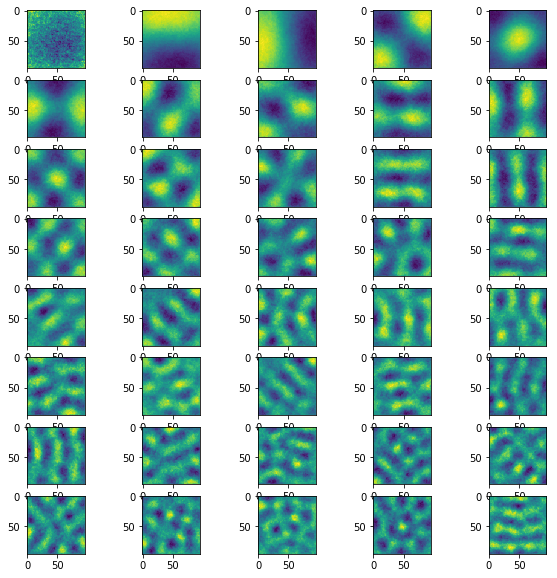

In [7]:
eigencells = pca.components_.reshape((n_comp, 96, 96))
fig = plt.figure(figsize=(10,10))
for idx in range(40):
    fig.add_subplot(8, 5,idx+1)
    imshow(eigencells[idx])

In [16]:
from skimage.measure import compare_ssim as ssim
#helper function to reconstruct image sourced from class jupyter notebook
def reconstruct_image(trans_obj,org_features):
    low_rep = trans_obj.transform(org_features)
    rec_image = trans_obj.inverse_transform(low_rep)
    return low_rep, rec_image

def reconstruct_by_prediction_class(trans_obj, pred_class):
    img_names = labels[labels.label == pred_class]
    ssim_values = []
    for index, row in img_names.head(1000).iterrows():
        try:
            idx_to_reconstruct = image_titles[:10000].index(row.id)
            X_idx = vec_images[idx_to_reconstruct]
            low_dim_rep, reconstructed_img = reconstruct_image(trans_obj, X_idx.reshape(1,-1))
            ssim_values.append(ssim(X_idx.reshape(96,96), reconstructed_img.reshape(96,96)))
        except Exception as e:
            pass
    return sum(ssim_values)/len(ssim_values)
        


print("SSIM for reconstruction of cancerous samples with normal PCA",reconstruct_by_prediction_class(pca, 1))
print("SSIM for reconstruction of noncancerous samples with normal PCA",reconstruct_by_prediction_class(pca, 0))

print("SSIM for reconstruction of cancerous samples with kernel PCA",reconstruct_by_prediction_class(X_kpca, 1))
print("SSIM for reconstruction of noncancerous samples with kernel PCA",reconstruct_by_prediction_class(X_kpca, 0))


SSIM for reconstruction of cancerous samples with normal PCA 0.8350618952269178
SSIM for reconstruction of noncancerous samples with normal PCA 0.7609858019969992
SSIM for reconstruction of cancerous samples with kernel PCA 0.6562161374193581
SSIM for reconstruction of noncancerous samples with kernel PCA 0.6159252203853005


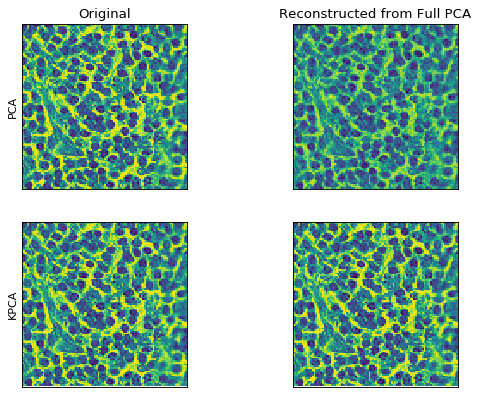

In [9]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
idx_to_reconstruct = 4 
X_idx = vec_images[idx_to_reconstruct]
low_dim_rep, reconstructed_img = reconstruct_image(pca,X_idx.reshape(1,-1))

low_dim_rep_kpca, reconstructed_img_kpca = reconstruct_image(X_kpca, X_idx.reshape(1,-1))

plt.subplot(2,2,1)
plt.xticks([])
plt.yticks([])
plt.ylabel('PCA')
plt.imshow(X_idx.reshape((96,96)))
plt.title('Original')
plt.subplot(2,2,2)
plt.xticks([])
plt.yticks([])
plt.imshow(reconstructed_img.reshape((96,96)))
plt.title('Reconstructed from Full PCA')
plt.subplot(2,2,3)
plt.ylabel('KPCA')
plt.xticks([])
plt.yticks([])
plt.imshow(reconstructed_img_kpca.reshape((96,96)))
plt.subplot(2,2,4)
plt.xticks([])
plt.yticks([])
plt.imshow(X_idx.reshape((96,96)))

In [10]:
def retrieve_by_prediction_class(pred_class):
    img_names = labels[labels.label == pred_class]
    img_vectors = []
    
    for index, row in img_names.head(1000).iterrows():
        try:
            img_vectors.append(vec_images[image_titles[:1000].index(row.id)])
        except Exception as e:
            pass
    return img_names, img_vectors

In [11]:
from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray


image_gray = rgb2gray(vec_images[2].reshape(96,96))

blobs_doh = blob_dog(image_gray, max_sigma=20, threshold=25, overlap=.4)



<h2> Feature extraction </h2><br>

<h4>To perform feature extraction, we fall back to the initial discussion on the difference between normal cells and cancerous cells. For this assignment, we intend to extract the features of large clusters of cancer cells and compare that with normal cells. When cancer cells are present, we can look for large patches or clusters in the image and use those features to predict the class. We did not use DAISY etc. as we weren't sure if there are global features across the dataset for cancerous cells. These images are captured from various samples and there is no reason to expect these to have features at the same locations that DAISY etc. can latch on to.So, we decided to use a simple difference of gaussian blob feature detector to detect blobs/patches in the dataset.</h4>

*<h4>What do we expect?</h4>*

<h4>We expect the blob detector to detect several blobs of small size (small radius or sigma parameter) in the images containing normal cells. At the same time, we expect the images having cancerous cells to have large blobs. We hope to see the histogram of the radii of blobs for images with normal cells to have lower mean and variance than the histogram of the radii of blobs for images with cancer cells. In the difference of gaussian (DOG) approach, the images are convolved with two gaussian filters of different scales and subtracted. This responds to edges and blobs in the image. Intuitively, this operation is like computing a derivative which is maximized whenever an edge is present in the image.</h4>

*<h4>Does the data match our prediction?</h4>*


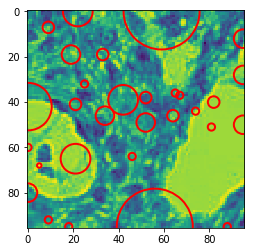

In [12]:
import numpy as np

fig, ax = plt.subplots(1)
ax.imshow(image_gray)
for blob in blobs_doh:
    x,y,r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax.add_patch(c)   

(20, 2)


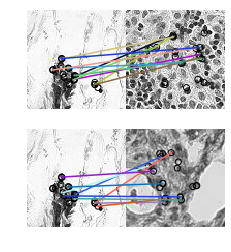

[70.   66.   63.6  46.8  64.   47.   72.   66.   67.   46.   72.   41.
 63.36 46.08 62.   35.   65.   36.   67.2  45.6  54.   33.   47.   34.
 72.   66.   56.   40.   58.   25.   46.8  33.6  75.   69.   67.68 46.08
 57.6  25.2  56.4  40.8 ]


In [13]:
# keypoint matching
from skimage import data
from skimage import transform as tf
from skimage.feature import (match_descriptors, corner_harris,
                             corner_peaks, ORB, plot_matches)
from matplotlib.pyplot import figure


descriptor_extractor = ORB(n_keypoints=20)

#code sourced from skimage ORB documentation, and adapted for our rgb, vectorized images
descriptor_extractor.detect_and_extract(rgb2gray(vec_images[0].reshape(96,96)))
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors
    
descriptor_extractor.detect_and_extract(rgb2gray(vec_images[1].reshape(96,96)))
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors
    
descriptor_extractor.detect_and_extract(rgb2gray(vec_images[2].reshape(96,96)))
keypoints3 = descriptor_extractor.keypoints
descriptors3 = descriptor_extractor.descriptors
    
matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)

matches13 = match_descriptors(descriptors1, descriptors3, cross_check=True)

print(keypoints1.shape)



    
fig, ax = plt.subplots(nrows=2, ncols=1)

plt.gray()

plot_matches(ax[0],rgb2gray(vec_images[0].reshape(96,96)), rgb2gray(vec_images[1].reshape(96,96)), keypoints1, keypoints2, matches12)
ax[0].axis('off')

plot_matches(ax[1], rgb2gray(vec_images[0].reshape(96,96)), rgb2gray(vec_images[2].reshape(96,96)), keypoints1, keypoints3, matches13)
ax[1].axis('off')

plt.show()
print(keypoints1.reshape(40))

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
keypoint_vectors = []
knn_targets = []
for idx, image in enumerate(vec_images[:1000]):
    try:
        descriptor_extractor.detect_and_extract(rgb2gray(image.reshape(96,96)))
        keypoint_vectors.append(descriptor_extractor.keypoints.reshape(40))
        knn_targets.append(targets[idx])
    except:
        pass

X_train, X_test, y_train, y_test = train_test_split(keypoint_vectors, knn_targets, test_size=0.33, random_state=42)
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_train, y_train)

print(neigh.predict(X_test[0].reshape(1,-1)))
print(y_test[0])


[1]
1


<h2> Classification </h2><br>

*How Classification With Keypoint Matching Can Be Achieved*
<br>
Classification can be achieved in this instance by vectorizing the features we extracted with keypoint matching, and treating them as features in a N dimensional space. These keypoints are matched to another image in the same order each time, so they can be vectorized in this way. In this case, we had 20 keypoints, each with 2 coordinates. We cast these into a 40 dimensional space, and performed KNN classification on the resulting points. This classification yields a - modestly - superior result to random chance because cancerous slides have cluseters that group near the center of the images, making the resulting feature vectors of cancerous cells group closer together than those without, which live at the edges of the 40 dimensional space.

This approach has its drawbacks. Our images make feature extraction in this way difficult, particularly with a blob detection scheme. This results in unreliable feature detection, and therefore modest results when the classification is performed. 


In [15]:
from sklearn.metrics import precision_score
y_true = []
y_pred = []
for x in range(100):
    y_pred.append(neigh.predict(X_test[x].reshape(1,-1)))
    y_true.append(y_test[x])
print("Accuracy of classifier with 20 keypoints and k = 1 nn:", round(precision_score(y_true, y_pred, average='binary')* 100, 2),'%' )

Accuracy of classifier with 20 keypoints and k = 1 nn: 54.84 %
